In [91]:
# ! pip install joblib imbalanced-learn
# ! pip install xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# from scipy.sparse import hstack
# from collections import Counter
# from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
    f1_score, confusion_matrix, classification_report, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler


from joblib import dump#, load

# csv, 폰트 경로, 모델 저장 경로
---

In [92]:
# 파일 경로
df_fin = pd.read_csv('./data/survey_results_cleaned_scaler.csv')
print(df_fin.info())

# 폰트 경로
font_path = 'C:/Windows/Fonts/gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font)

# 모델 저장 경로
model_path = "./model/"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59265 entries, 0 to 59264
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   LearnCode_count   59265 non-null  int64  
 1   Lang_Diversity    59265 non-null  int64  
 2   AI_Tool_Count     59265 non-null  int64  
 3   WorkExp           59265 non-null  float64
 4   YearsCode         59265 non-null  float64
 5   DevRole_Count     59265 non-null  int64  
 6   SOHow_count       59265 non-null  int64  
 7   SOComm_encoded    59265 non-null  int64  
 8   NEWSOSites_count  59265 non-null  int64  
 9   Age_encoded       59265 non-null  float64
 10  Challenges_count  59265 non-null  int64  
 11  AIForecastScore   59265 non-null  int64  
 12  AIThreat_num      59265 non-null  float64
 13  is_churned        59265 non-null  int64  
dtypes: float64(4), int64(10)
memory usage: 6.3 MB
None


In [93]:
# 타겟 변수 분리
X = df_fin.drop('is_churned', axis=1)
y = df_fin['is_churned']

# 오버샘플링
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

# 스케일링 객체 생성
scaler = MinMaxScaler()

# X 스케일링
X_scaled = scaler.fit_transform(X)

# 학습, 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=42)

# def
---

In [94]:
model_y_pred = {}
# 모델 학습 및 성능 출력
def train_and_evaluate(model, X_train, y_train, X_test, y_test, threshold=None):
    # 모델 학습
    model.fit(X_train, y_train)

    # threshold : 임계값 입력 받았을 때
    if threshold is not None:
        prob = model.predict_proba(X_test)
        y_pred = (prob[:, 1] > threshold).astype(int)
    else:
        # 예측 확률 계산
        prob = model.predict_proba(X_test)[:, 1]

        # Precision-Recall Curve 기반 최적 임계값 탐색
        precs, recs, thrs = precision_recall_curve(y_test, prob)
        f1s = 2 * precs * recs / (precs + recs + 1e-8)
        best_idx = f1s.argmax()
        best_thr = thrs[best_idx] if best_idx < len(thrs) else 0.5
        print(f"🔍 최적 임계값 (Optimal threshold): {best_thr:.2f}")

        # 임계값 적용하여 예측
        y_pred = (prob >= best_thr).astype(int)

    # 성능 출력
    print("✅ 학습 정확도:", accuracy_score(y_train, model.predict(X_train)))
    print()
    print("✅ 정확도 (Accuracy):", accuracy_score(y_test, y_pred))
    print("✅ 정밀도 (Precision):", precision_score(y_test, y_pred, zero_division=0))
    print("✅ 재현율 (Recall):", recall_score(y_test, y_pred, zero_division=0))
    print("✅ F1 Score:", f1_score(y_test, y_pred, zero_division=0))
    print("\n📊 혼동 행렬 (Confusion Matrix):\n", confusion_matrix(y_test, y_pred))
    print("\n📋 분류 리포트 (Classification Report):\n", classification_report(y_test, y_pred))
    model_y_pred[model.__class__.__name__] = y_pred
    # return best_thr, y_pred

In [95]:
# 모델 시각화
def plot_feature_importance(importance_df, model):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis', hue='feature')
    plt.title(f"{model.__class__.__name__} 변수 중요도", fontsize=15)
    plt.xlabel("중요도")
    plt.ylabel("특성")
    plt.tight_layout()
    plt.grid(True)
    plt.show()
    pass

# LogisticRegression
---

In [96]:
logreg = LogisticRegression(
    penalty='l2',
    C=1.0,
    class_weight='balanced',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
# 성능 출력
print("LogisticRegression:")
train_and_evaluate(logreg, X_train, y_train, X_test, y_test)

LogisticRegression:
🔍 최적 임계값 (Optimal threshold): 0.41
✅ 학습 정확도: 0.7764806104818583

✅ 정확도 (Accuracy): 0.7719026707940393
✅ 정밀도 (Precision): 0.7307551319648093
✅ 재현율 (Recall): 0.861061118709956
✅ F1 Score: 0.7905747050464325

📊 혼동 행렬 (Confusion Matrix):
 [[ 9484  4407]
 [ 1930 11961]]

📋 분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.83      0.68      0.75     13891
           1       0.73      0.86      0.79     13891

    accuracy                           0.77     27782
   macro avg       0.78      0.77      0.77     27782
weighted avg       0.78      0.77      0.77     27782



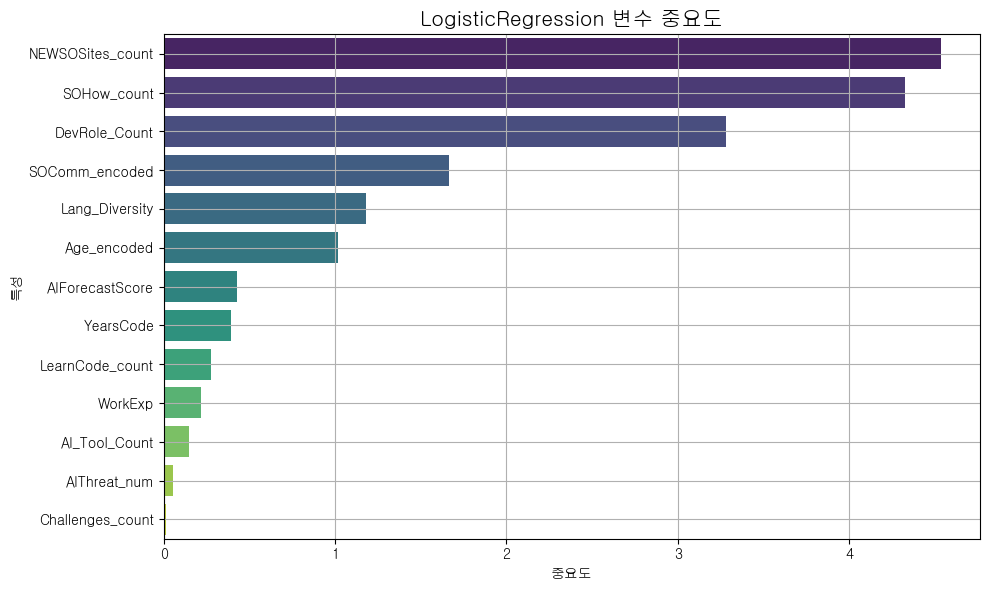

In [97]:
# 시각화
model = logreg
coefs = model.coef_[0]
features = X.columns
importance_df = pd.DataFrame({
    'feature': features,
    'importance': np.abs(coefs)
}).sort_values(by='importance', ascending=False)

plot_feature_importance(importance_df, model)

# GradientBoostingClassifier
---

In [98]:
gbm = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
# 성능 출력
print("GradientBoostingClassifier:")
train_and_evaluate(gbm, X_train, y_train, X_test, y_test)

GradientBoostingClassifier:
🔍 최적 임계값 (Optimal threshold): 0.50
✅ 학습 정확도: 0.9035683432520637

✅ 정확도 (Accuracy): 0.9006191058959038
✅ 정밀도 (Precision): 0.9210805084745762
✅ 재현율 (Recall): 0.876322798934562
✅ F1 Score: 0.8981443907477773

📊 혼동 행렬 (Confusion Matrix):
 [[12848  1043]
 [ 1718 12173]]

📋 분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.88      0.92      0.90     13891
           1       0.92      0.88      0.90     13891

    accuracy                           0.90     27782
   macro avg       0.90      0.90      0.90     27782
weighted avg       0.90      0.90      0.90     27782



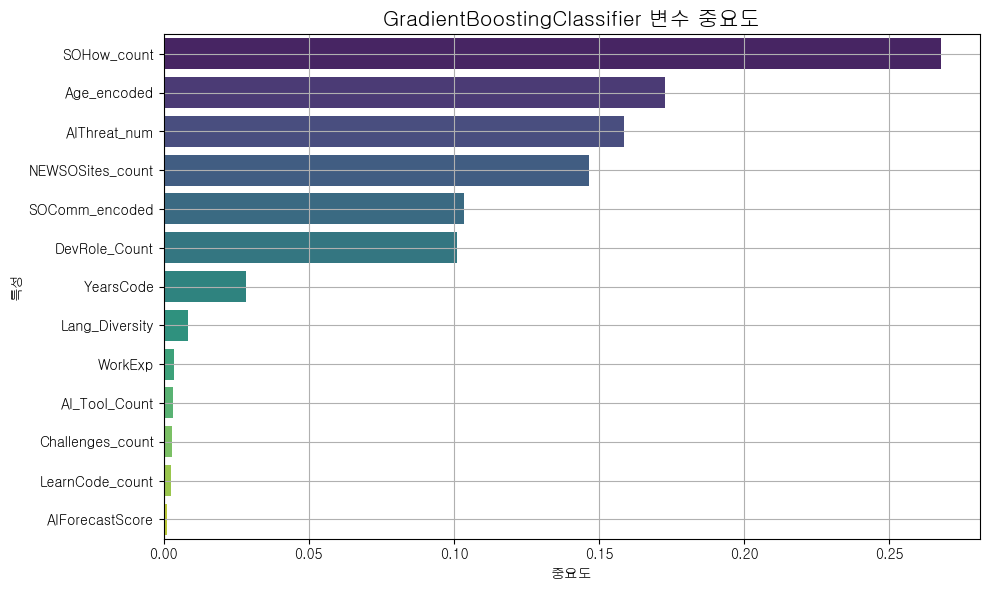

In [99]:
# 시각화
model = gbm
importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plot_feature_importance(importance_df, model)

# RandomForestClassifier
---

In [100]:
rf_clf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    max_features='sqrt',
    random_state=42,
    max_depth=15,
    min_samples_split=10,
)
# 성능 출력
print('RandomForestClassifier')
train_and_evaluate(rf_clf, X_train, y_train, X_test, y_test)

RandomForestClassifier
🔍 최적 임계값 (Optimal threshold): 0.49
✅ 학습 정확도: 0.941183528508351

✅ 정확도 (Accuracy): 0.9141530487365921
✅ 정밀도 (Precision): 0.90859375
✅ 재현율 (Recall): 0.9209560146857677
✅ F1 Score: 0.9147331164420293

📊 혼동 행렬 (Confusion Matrix):
 [[12604  1287]
 [ 1098 12793]]

📋 분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.92      0.91      0.91     13891
           1       0.91      0.92      0.91     13891

    accuracy                           0.91     27782
   macro avg       0.91      0.91      0.91     27782
weighted avg       0.91      0.91      0.91     27782



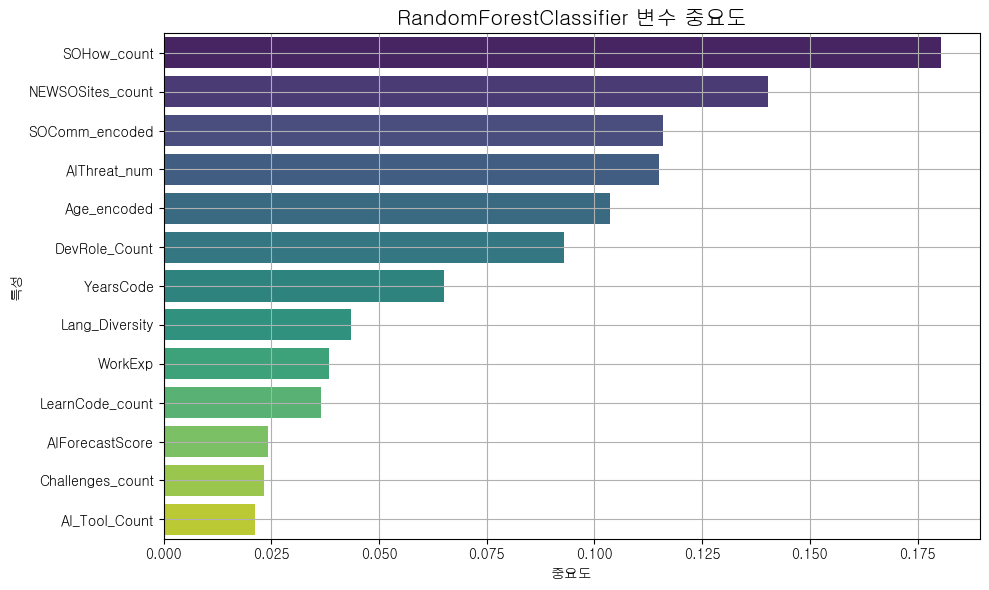

In [101]:
# 시각화
model = rf_clf
importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plot_feature_importance(importance_df, model)

# XGBClassifier
---

In [102]:
neg, pos = np.bincount(y_train.astype(int))
scale = neg / pos
xgb = XGBClassifier(
    enable_categorical=True,
    scale_pos_weight=scale,
    eval_metric='logloss',
    random_state=42
)
# 성능 출력
print("XGBClassifier:")
train_and_evaluate(xgb, X_train, y_train, X_test, y_test)

XGBClassifier:
🔍 최적 임계값 (Optimal threshold): 0.46
✅ 학습 정확도: 0.9445550969475907

✅ 정확도 (Accuracy): 0.9326542365560435
✅ 정밀도 (Precision): 0.9456473379801276
✅ 재현율 (Recall): 0.9180764523792384
✅ F1 Score: 0.9316579610622056

📊 혼동 행렬 (Confusion Matrix):
 [[13158   733]
 [ 1138 12753]]

📋 분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.92      0.95      0.93     13891
           1       0.95      0.92      0.93     13891

    accuracy                           0.93     27782
   macro avg       0.93      0.93      0.93     27782
weighted avg       0.93      0.93      0.93     27782



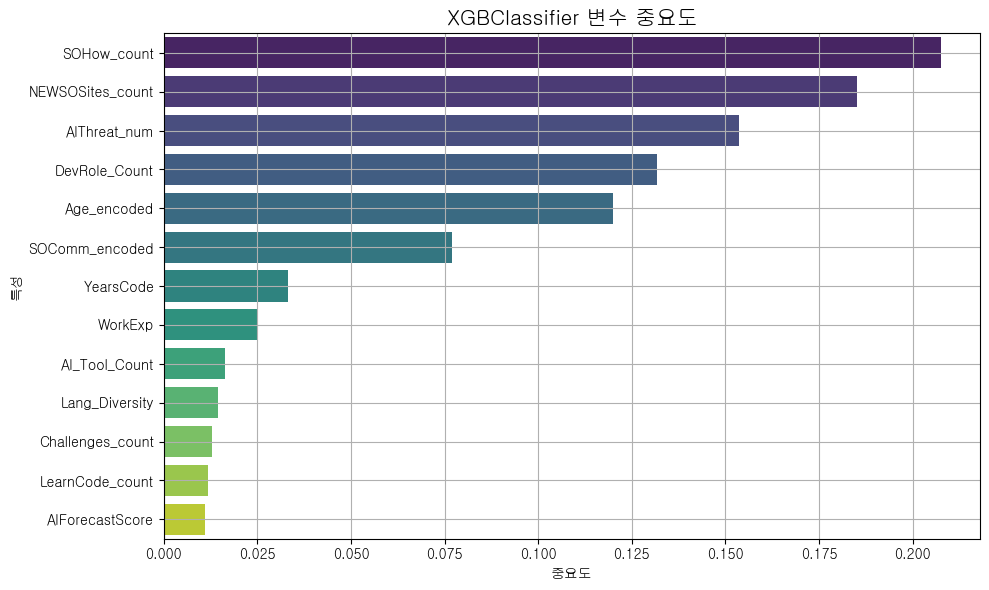

In [103]:
# 시각화
model = xgb
importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plot_feature_importance(importance_df, model)

# DecisionTreeClassifier
---

In [104]:
clf_tree = DecisionTreeClassifier(max_depth=15, random_state=42)
# 성능 출력
print("DecisionTreeClassifier:")
train_and_evaluate(clf_tree, X_train, y_train, X_test, y_test)

DecisionTreeClassifier:
🔍 최적 임계값 (Optimal threshold): 0.36
✅ 학습 정확도: 0.9341524284891534

✅ 정확도 (Accuracy): 0.8811100712691671
✅ 정밀도 (Precision): 0.8550637156270959
✅ 재현율 (Recall): 0.9177884961485854
✅ F1 Score: 0.8853164820665949

📊 혼동 행렬 (Confusion Matrix):
 [[11730  2161]
 [ 1142 12749]]

📋 분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.91      0.84      0.88     13891
           1       0.86      0.92      0.89     13891

    accuracy                           0.88     27782
   macro avg       0.88      0.88      0.88     27782
weighted avg       0.88      0.88      0.88     27782



# CatBoostClassifier
---

In [105]:
from catboost import CatBoostClassifier
print('CatBoostClassifier:')
cb_clf = CatBoostClassifier(iterations=300, depth=6, learning_rate=0.05, 
                           loss_function='Logloss', eval_metric='AUC',
                           random_seed=42, verbose=False)
train_and_evaluate(cb_clf, X_train, y_train, X_test, y_test)

CatBoostClassifier:
🔍 최적 임계값 (Optimal threshold): 0.46
✅ 학습 정확도: 0.9269293530428105

✅ 정확도 (Accuracy): 0.9245914620977611
✅ 정밀도 (Precision): 0.9392314566577301
✅ 재현율 (Recall): 0.9079259952487222
✅ F1 Score: 0.9233134448552289

📊 혼동 행렬 (Confusion Matrix):
 [[13075   816]
 [ 1279 12612]]

📋 분류 리포트 (Classification Report):
               precision    recall  f1-score   support

           0       0.91      0.94      0.93     13891
           1       0.94      0.91      0.92     13891

    accuracy                           0.92     27782
   macro avg       0.93      0.92      0.92     27782
weighted avg       0.93      0.92      0.92     27782



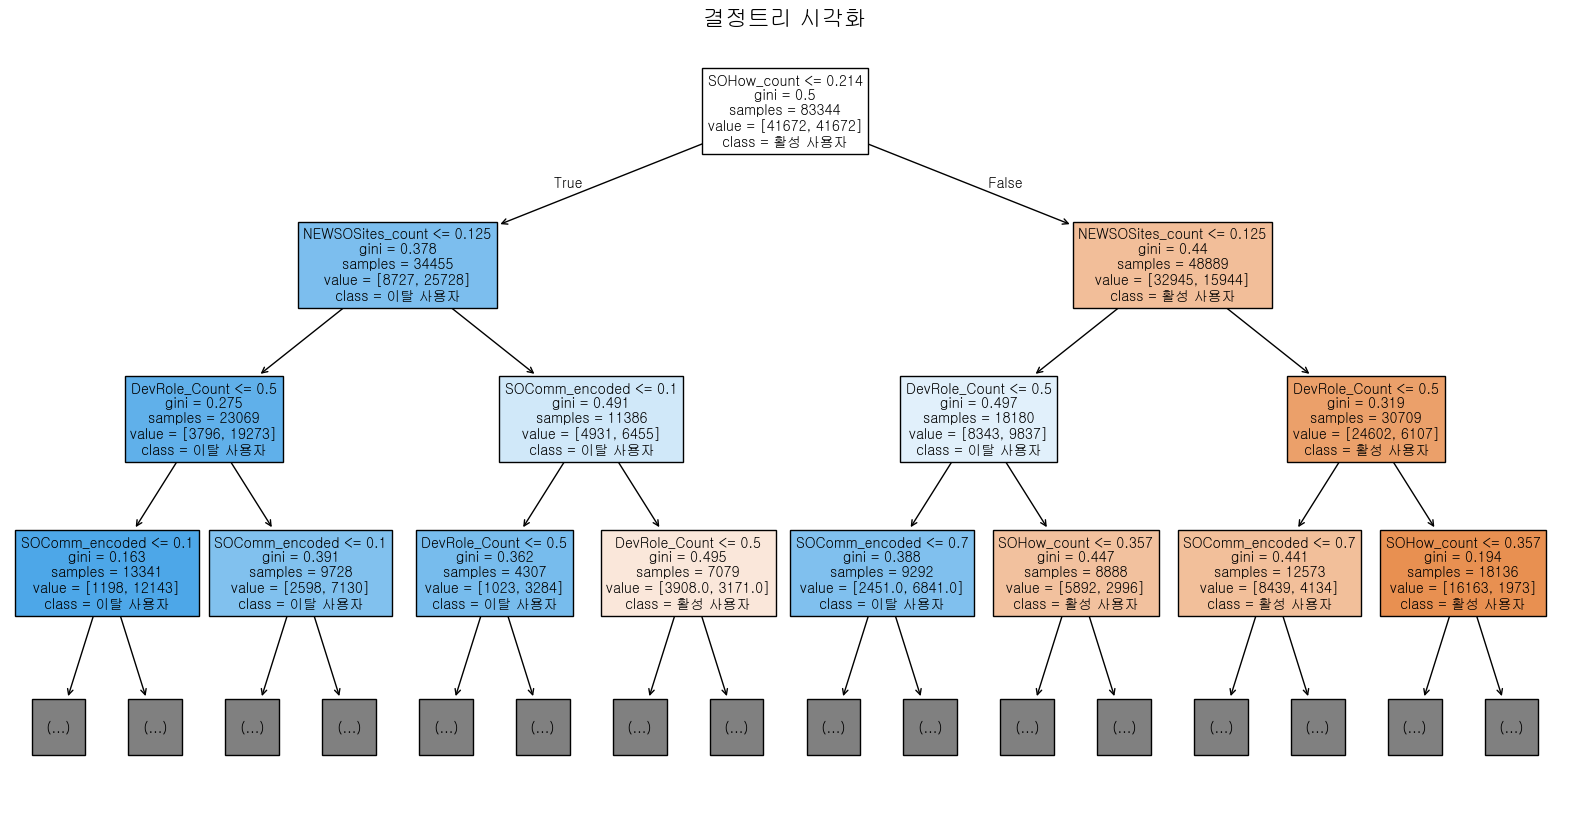

In [106]:
plt.figure(figsize=(20, 10))
plot_tree(clf_tree, feature_names=X.columns, class_names=['활성 사용자', '이탈 사용자'], filled=True, max_depth=3, fontsize=10)
plt.title("결정트리 시각화", fontsize=16)
plt.show()

# 모델 저장
---

In [107]:
# dump(logreg, f'{model_path}logreg_model.joblib')
# dump(gbm, f'{model_path}gbm_model.joblib')
# dump(rf_clf, f'{model_path}rf_model.joblib')
# dump(xgb, f'{model_path}xgb_model.joblib')
# dump(clf_tree, f'{model_path}xgb_model.joblib')

In [108]:
# # X, y 병합
df_smote = pd.concat([X, y], axis=1)
# df_smote.info()

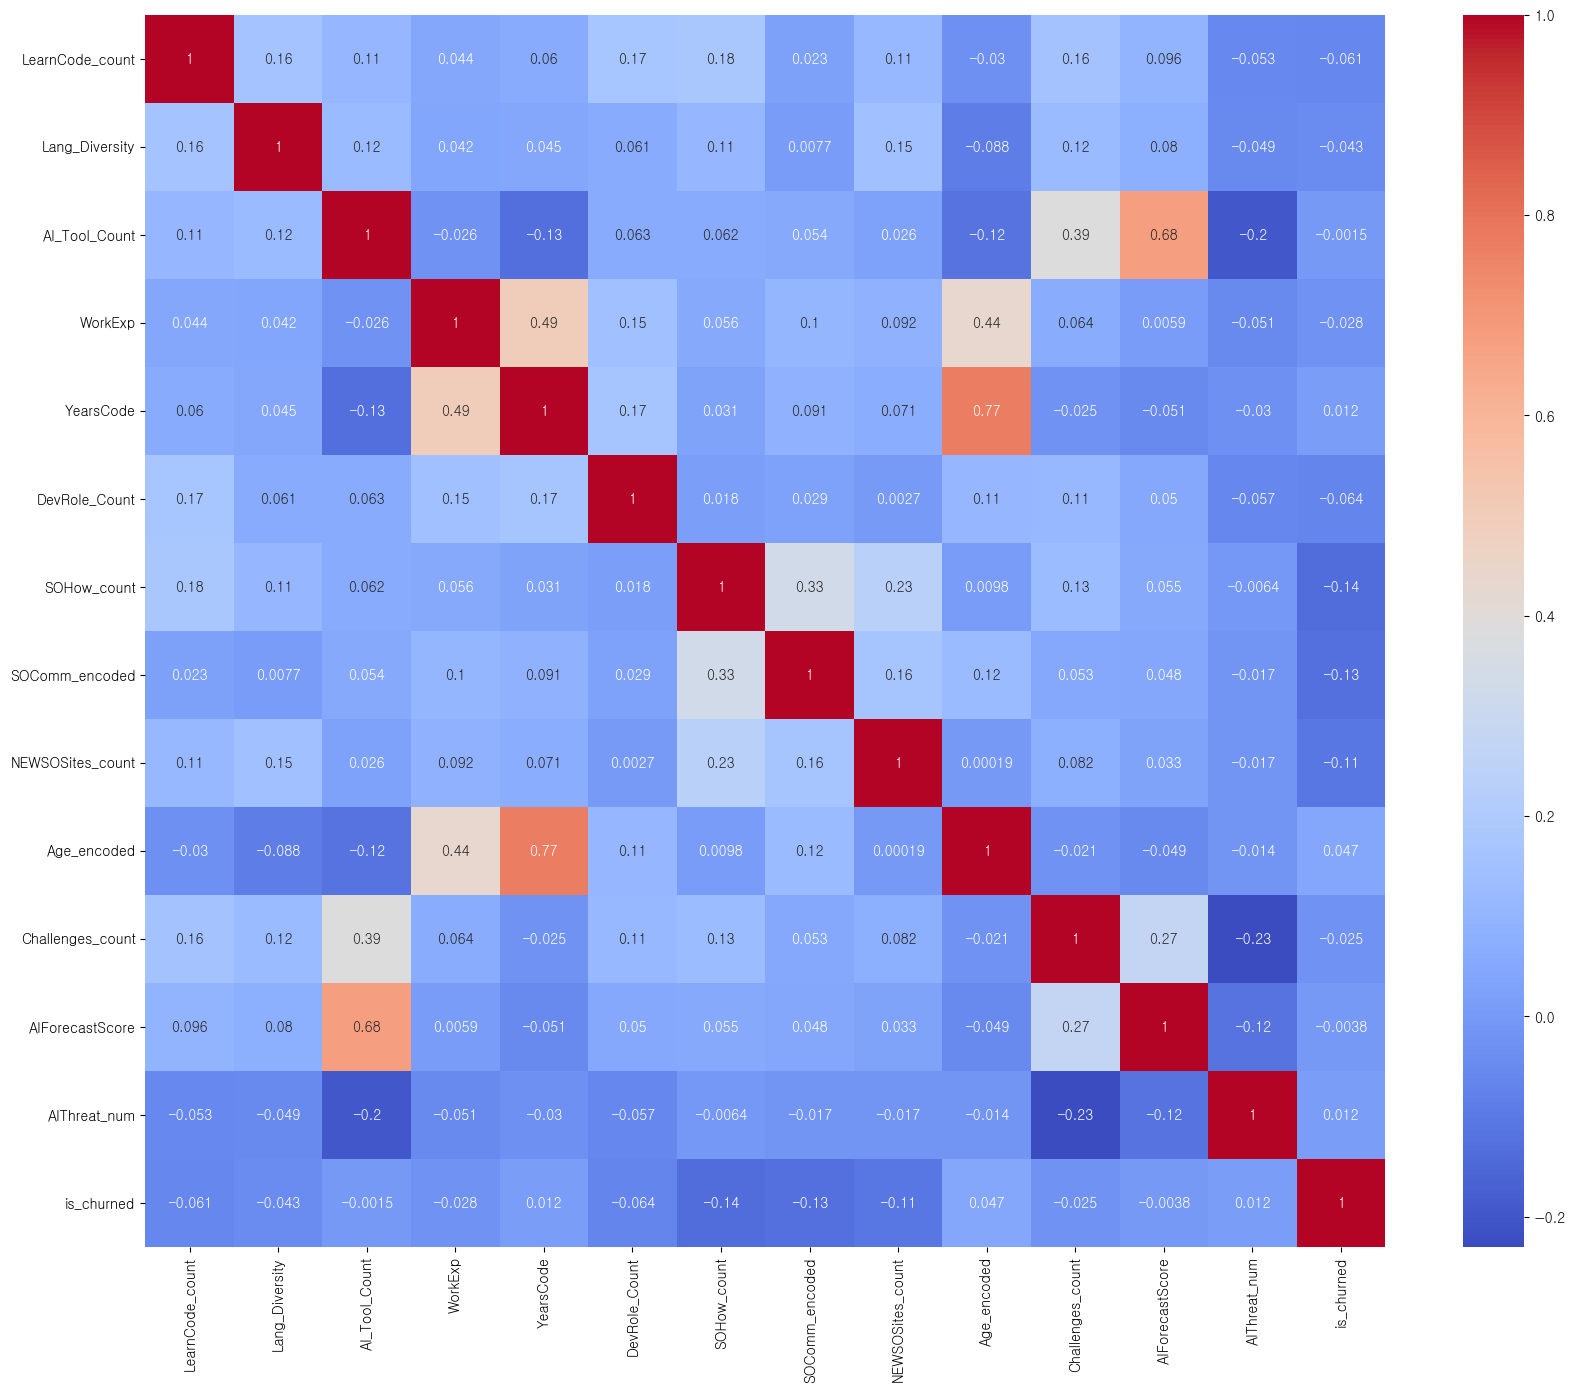

In [109]:
plt.figure(figsize=(20, 16))
sns.heatmap(df_fin.corr(), annot=True, cmap='coolwarm')
plt.show()

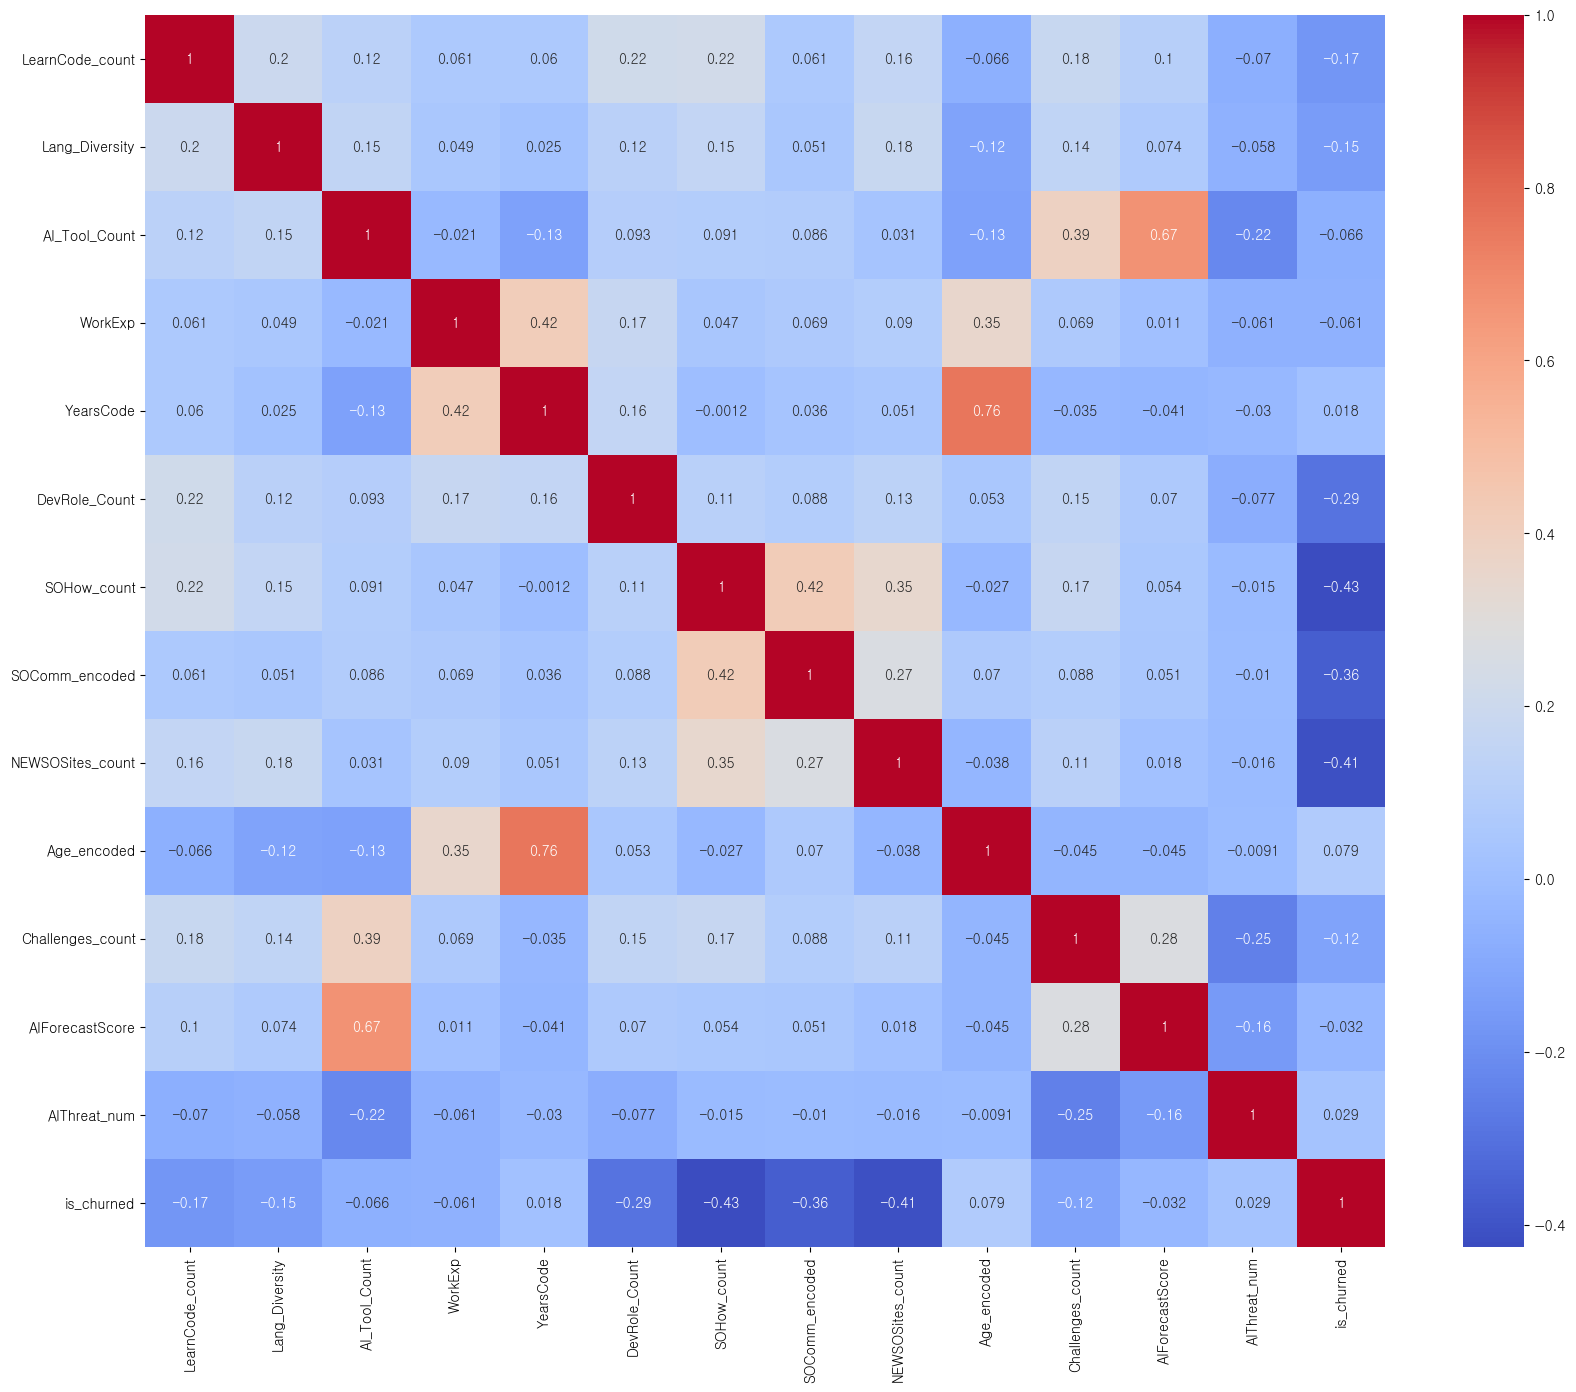

In [110]:
plt.figure(figsize=(20, 16))
sns.heatmap(df_smote.corr(), annot=True, cmap='coolwarm')
plt.show()

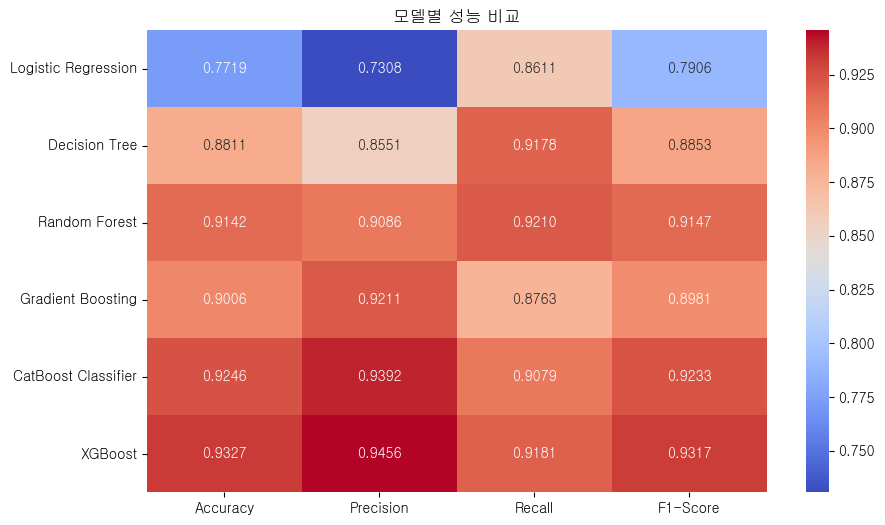

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 각 모델의 예측 결과를 저장할 딕셔너리
results = {}

# 평가할 모델 리스트
models = {
    "Logistic Regression": logreg,
    "Decision Tree": clf_tree,
    "Random Forest": rf_clf,
    "Gradient Boosting": gbm,
    "CatBoost Classifier": cb_clf,
    "XGBoost": xgb
}

# 이전에 찾은 임계값을 사용
for name, model in models.items():
    y_pred = model_y_pred[model.__class__.__name__]
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    }

# 결과를 DataFrame으로 변환
results_df = pd.DataFrame(results).T

# 히트맵 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(results_df, annot=True, cmap='coolwarm', fmt='.4f')
plt.title('모델별 성능 비교', fontsize=12)
plt.show()

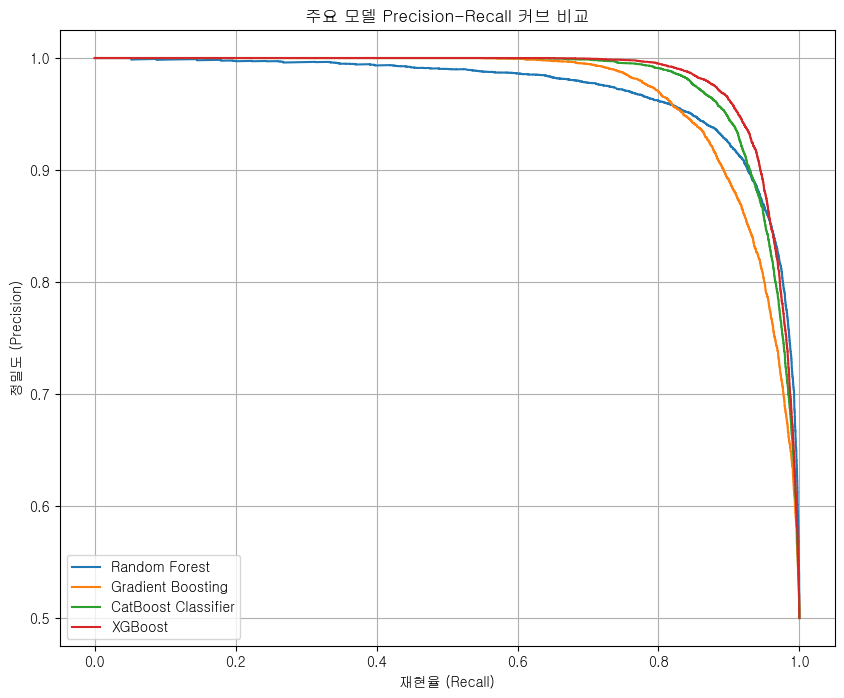

In [112]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(10, 8))

# 상위 성능 모델 3개 + CatBoost 정도를 비교하는 것이 좋습니다.
top_models = {
    "Random Forest": rf_clf,
    "Gradient Boosting": gbm,
    "CatBoost Classifier": cb_clf,
    "XGBoost": xgb
}

for name, model in top_models.items():
    # 1 (이탈) 클래스에 대한 예측 확률
    y_probs = model.predict_proba(X_test)[:, 1]
    
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    plt.plot(recall, precision, label=name)

plt.xlabel('재현율 (Recall)')
plt.ylabel('정밀도 (Precision)')
plt.title('주요 모델 Precision-Recall 커브 비교', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

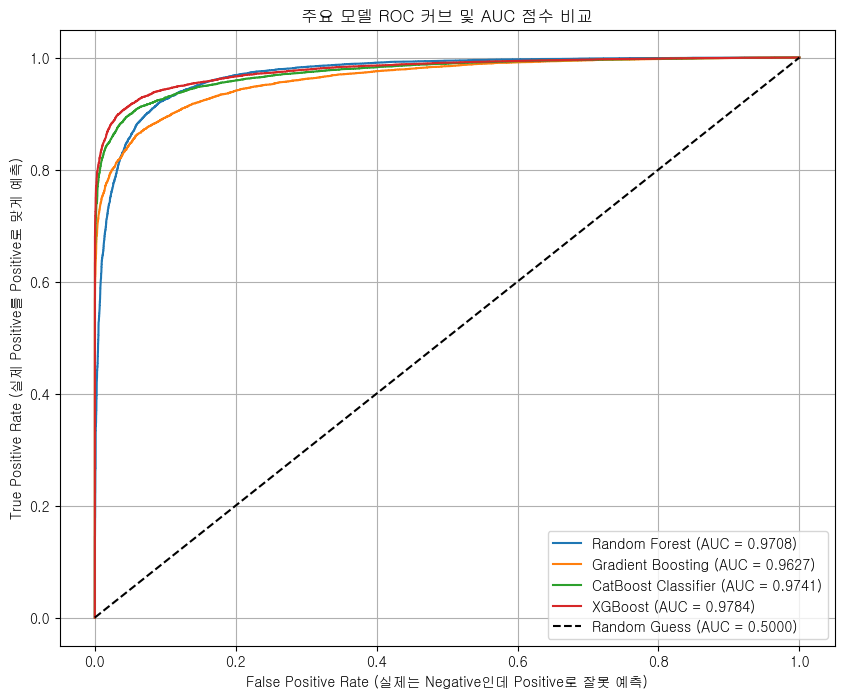

In [113]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

# 비교할 모델 리스트 (Precision-Recall 커브와 동일하게)
top_models = {
    "Random Forest": rf_clf,
    "Gradient Boosting": gbm,
    "CatBoost Classifier": cb_clf,
    "XGBoost": xgb
}

for name, model in top_models.items():
    # 1 (이탈) 클래스에 대한 예측 확률
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # ROC 커브 계산
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    
    # AUC 점수 계산
    roc_auc = auc(fpr, tpr)
    
    # 그래프 그리기 (범례에 AUC 점수 포함)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

# 랜덤 추측선 (기준선)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5000)')

# 그래프 설정
plt.xlabel('False Positive Rate (실제는 Negative인데 Positive로 잘못 예측)')
plt.ylabel('True Positive Rate (실제 Positive를 Positive로 맞게 예측)')
plt.title('주요 모델 ROC 커브 및 AUC 점수 비교', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

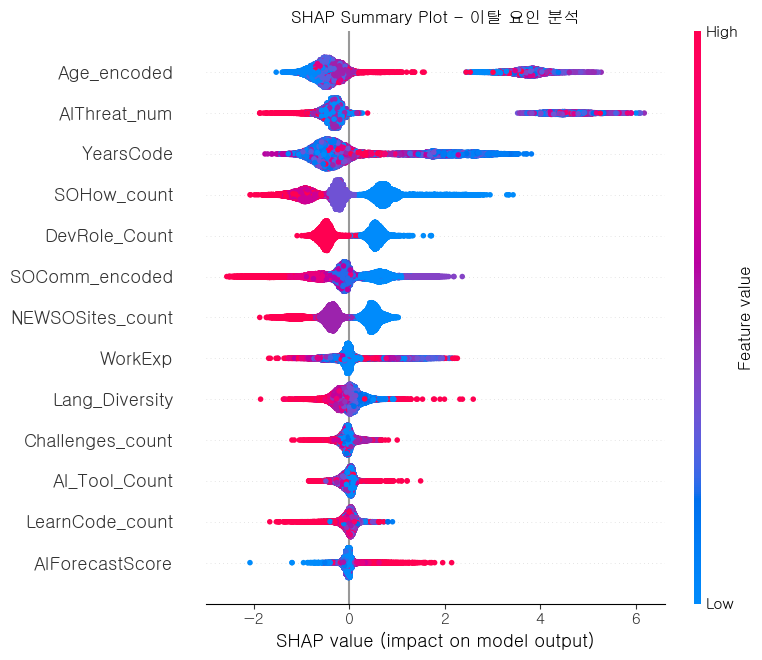

In [114]:
# !pip install shap
import shap

# SHAP explainer 생성 (XGBoost 모델 사용)
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

# Summary Plot 시각화
# X_test는 스케일링된 numpy 배열이므로, 피처 이름을 위해 pandas DataFrame으로 변환
X_test_df = pd.DataFrame(X_test, columns=X.columns)

plt.title('SHAP Summary Plot - 이탈 요인 분석', fontsize=12)
shap.summary_plot(shap_values, X_test_df, plot_type="dot", show=False)
plt.show()